In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

In [6]:
# Load dataset
df = pd.read_csv("ecg_autoencoder_dataset.csv", header=None)

display(df.head())
print(df.shape, df.columns.tolist())

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


(4998, 141) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140]


In [7]:
# Features (all columns except last) and label (last column)
X = df.iloc[:, :-1].astype("float32").values
y = df.iloc[:, -1].astype("float32").values

print("Feature shape: ", X.shape, "| Label shape: ", y.shape, "| Unique labels: ", np.unique(y))

Feature shape:  (4998, 140) | Label shape:  (4998,) | Unique labels:  [0. 1.]


In [11]:
# Train/test split (stratify to preserve class ratio)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Keep only NORMAL beats for training
X_train_norm = X_train_all[y_train_all == 1]

# Train/val split (Normal only)
Xn_train, Xn_val = train_test_split(X_train_norm, test_size=0.2, random_state=42)

# Scale using statistics from NORMAL TRAIN only
scaler = MinMaxScaler().fit(Xn_train)
Xn_train_s = scaler.transform(Xn_train)
Xn_val_s = scaler.transform(Xn_val)
X_test_s = scaler.transform(X_test_all) # contains both normal and abnormal
y_test = y_test_all.copy()

print("Xn_train_s: ", Xn_train_s.shape, "| Xn_val_s: ", Xn_val_s.shape, "| X_test_s: ", X_test_s.shape)

Xn_train_s:  (1868, 140) | Xn_val_s:  (467, 140) | X_test_s:  (1000, 140)


In [12]:
# Encoder -> latent representation
# Decoder -> reconstruct original input

# Build autoencoder
input_dim = Xn_train_s.shape[1] # number of time samples per beat
latent_dim = 16

inputs = keras.Input(shape=(input_dim,), name="input_ecg")

# Encoder
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
latent = layers.Dense(latent_dim, activation="relu", name="latent")(x)

# Decoder
x = layers.Dense(32, activation="relu")(latent)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(input_dim, activation=None, name="reconstruction")(x)

autoencoder = keras.Model(inputs, outputs, name="ecg_autoencoder")
autoencoder.summary()

Model: "ecg_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ecg (InputLayer)               │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           9,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstruction (Dense)               │ (None, 140)                 │           9,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,388 (91.36 KB)

 Trainable params: 23,388 (91.36 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile 
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mse"]
)

history = autoencoder.fit(
    Xn_train_s, Xn_train_s,
    validation_data=(Xn_val_s, Xn_val_s),
    epochs=20,
    batch_size=512,
    shuffle=True,
    verbose=2
)

Epoch 1/20
4/4 - 2s - 520ms/step - loss: 0.2842 - mse: 0.2842 - val_loss: 0.2651 - val_mse: 0.2651
Epoch 2/20
4/4 - 0s - 27ms/step - loss: 0.2520 - mse: 0.2520 - val_loss: 0.2250 - val_mse: 0.2250
Epoch 3/20
4/4 - 0s - 27ms/step - loss: 0.2103 - mse: 0.2103 - val_loss: 0.1842 - val_mse: 0.1842
Epoch 4/20
4/4 - 0s - 29ms/step - loss: 0.1687 - mse: 0.1687 - val_loss: 0.1401 - val_mse: 0.1401
Epoch 5/20
4/4 - 0s - 28ms/step - loss: 0.1265 - mse: 0.1265 - val_loss: 0.1029 - val_mse: 0.1029
Epoch 6/20
4/4 - 0s - 26ms/step - loss: 0.0917 - mse: 0.0917 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 7/20
4/4 - 0s - 28ms/step - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 8/20
4/4 - 0s - 28ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 9/20
4/4 - 0s - 28ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 10/20
4/4 - 0s - 30ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 11/20
4/4 - 

In [35]:
# Reconstruction error into anomaly detection

# Per-sample reconstruction error (MSE across features)
def recon_error(model, data):
    recon = model.predict(data, verbose=0)
    return np.mean((data - recon) ** 2, axis=1)

# Errors for normal validation (to set threshold) + test errors for evaluation
err_val_norm = recon_error(autoencoder, Xn_val_s)
err_test = recon_error(autoencoder, X_test_s)

threshold = np.percentile(err_val_norm, 92)
print(f"Chosen threshold (92nd percentile from normal val): {threshold:.6f}")

# Predict anomalies on test
y_pred = (err_test > threshold).astype(int)

# Map ground truth to anomaly=1 (assuming 1=normal, 0=anomaly)
y_true = (y_test == 0).astype(int)

# Report metrics
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, err_test) # using error as the anomaly score
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f} Recall: {rec:.4f} F1: {f1:.4f} ROC-AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)

Chosen threshold (92nd percentile from normal val): 0.026565
Accuracy: 0.9500
Precision: 0.9103 Recall: 0.9760 F1: 0.9420 ROC-AUC: 0.9660
Confusion Matrix:
 [[544  40]
 [ 10 406]]


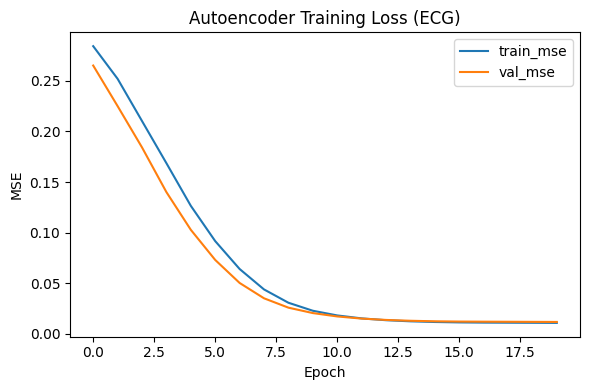

In [30]:
# Training curves
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_mse")
plt.plot(history.history["val_loss"], label="val_mse")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Autoencoder Training Loss (ECG)")
plt.legend(); plt.tight_layout(); plt.show()

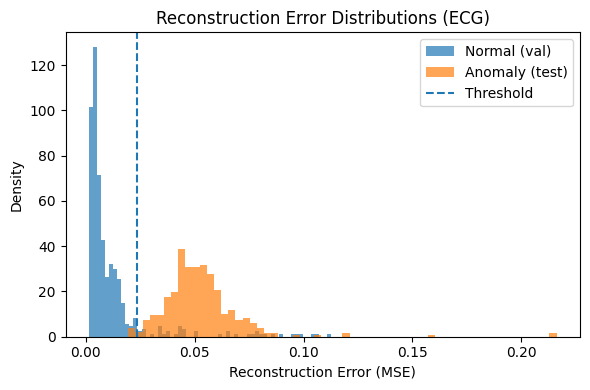

In [31]:
# 2) Error distributions (normalized density)
err_test_norm = err_test[y_true == 0]   # true normals
err_test_anom = err_test[y_true == 1]   # true anomalies

plt.figure(figsize=(6,4))
plt.hist(err_val_norm, bins=60, alpha=0.7, density=True, label="Normal (val)")
plt.hist(err_test_anom, bins=60, alpha=0.7, density=True, label="Anomaly (test)")
plt.axvline(threshold, linestyle="--", label="Threshold")
plt.xlabel("Reconstruction Error (MSE)"); plt.ylabel("Density")
plt.title("Reconstruction Error Distributions (ECG)")
plt.legend(); plt.tight_layout(); plt.show()